## A simple and quick tutorial of training and using a scPred model

In [223]:
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# specify the device that you'll use cpu or gpu
device = torch.device('cpu')

### * Train the model through command line

Get into the folder where there are `scPred_train.json`, `scPred_train.py`, `scPred_utils.py`, then run:
`python scPred_train.py --parameters scPred_train.json --cell_file [the training data]`

You may need to modify the format of the training data to be loaded properly.

### Train the model in the jupyter notebook

### 1. Pre-process the epigenomics file and expression file

...
Finally, we should have a epigenomic plus expression data file in pickle, hdf5 or plain text file like csv format.

### 2. Load, split and normalize the data

In [225]:
# load the data (format in .csv as an example)
gen_data_p = '../../Training_data/csv_format/Naive_B_cell.csv'
gen_data = pd.read_csv(gen_data_p, index_col=0)
gen_data

,gene_name,chromo,0,1,2,3,4,5,6,7,...,5304,5305,5306,5307,5308,5309,5310,5311,5312,naive_B_cell
0,ATAD3B,chr1,4.067672,3.647823,3.452344,1.299412,3.855479,5.222215,2.045481,3.731929,...,18.675581,5.115639,2.431887,13.102445,11.133468,12.352341,6.391345,44.084885,35.792460,0.617056
1,PRDM16,chr1,0.498504,1.675415,2.539938,0.854715,1.221890,1.847521,0.682262,1.584615,...,8.574609,2.558510,0.992156,1.272036,0.732018,0.469596,0.706452,6.196827,2.001932,0.282881
2,PEX10,chr1,10.101708,9.151280,8.493706,2.824118,9.172377,12.190944,4.258388,8.590059,...,18.780680,4.764785,1.875605,5.743251,4.771894,5.098137,3.299817,22.212410,18.264761,0.662931
3,PEX14,chr1,3.370678,2.529378,2.635246,1.991302,3.375057,4.478309,1.939699,2.746556,...,25.391914,7.708267,3.753296,8.385046,5.592999,9.346388,4.087106,33.755790,27.300919,0.607691
4,PLCH2,chr1,0.605982,0.576329,1.703161,0.194556,0.332990,0.525577,0.195734,0.522762,...,0.054706,0.037895,0.020515,0.004426,0.010619,0.004440,0.009288,0.029449,0.025027,0.523253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19015,CDY1,chrY,0.061454,0.053432,0.042596,0.143704,0.066984,0.065173,0.089574,0.071284,...,0.024388,0.014798,0.010509,0.009670,0.004928,0.005688,0.011484,0.022792,0.033220,0.083149
19016,TSPY4,chrY,0.006602,0.008855,0.014377,0.004839,0.007068,0.006743,0.003853,0.004656,...,0.028789,0.010153,0.006920,0.004809,0.000975,0.003088,0.003367,0.007086,0.005846,0.083149
19017,RBMY1J,chrY,4.402741,2.632909,1.950478,2.554271,4.028593,5.287105,2.040063,2.882508,...,36.216583,9.859616,6.790904,23.670513,16.321886,19.252650,9.462907,54.479164,50.710040,0.083149
19018,RBMY1B,chrY,3.020573,1.685974,1.149323,1.760193,3.046081,4.016865,1.424957,2.056236,...,34.106220,9.027244,6.281546,31.079556,21.288475,26.648651,12.893337,65.193794,61.583122,0.083149


This is an example of the data to feed the model. Each row is a gene, with gene name, chromosome, 5313 different epigenomic features at the TSS, and the population-average expression level in certain cell types.

In [213]:
# define the training, validation, and test set by chromosomes 
train_set = ["chr1", "chr10", "chr13", "chr15", "chr16", "chr17", "chr18", "chr19", "chr2", "chr21", "chr22", "chr3", "chr4", "chr6", "chr8", "chr9", "chrX", "chrY"]
val_set = ["chr11", "chr14", "chr7"]
test_set = ["chr12", "chr20", "chr5"]


def data_prepare(gen_data, train_set, val_set, test_set, is_normalization=True):
    # split the data
    train_data = gen_data[gen_data['chromo'].isin(train_set)]
    val_data = gen_data[gen_data['chromo'].isin(val_set)]
    test_data = gen_data[gen_data['chromo'].isin(test_set)]


    # choose naive B cell as an example to train a model for gene expression prediction
    train_epi = torch.tensor(train_data.iloc[:, 2:5315].values, dtype=torch.float32).to(device)
    train_exp = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.float32).to(device)

    val_epi = torch.tensor(val_data.iloc[:, 2:5315].values, dtype=torch.float32).to(device)
    val_exp = torch.tensor(val_data.iloc[:, -1].values, dtype=torch.float32).to(device)

    test_epi = torch.tensor(test_data.iloc[:, 2:5315].values, dtype=torch.float32).to(device)
    test_exp = torch.tensor(test_data.iloc[:, -1].values, dtype=torch.float32).to(device)

    if is_normalization:
        # normalize the input data (this step is not necessary but recommanded)
        scaler = StandardScaler().fit(train_epi)
        train_epi = torch.tensor(scaler.transform(train_epi), dtype=torch.float32).to(device)
        val_epi = torch.tensor(scaler.transform(val_epi), dtype=torch.float32).to(device)
        test_epi = torch.tensor(scaler.transform(test_epi), dtype=torch.float32).to(device)

    return train_epi, train_exp, val_epi, val_epi, val_exp, test_epi, test_exp


# put the data into a iterator which reads data in batches
def dataloader(features, labels, batch_size, is_train = True):
    dataset = data.TensorDataset(features, labels)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)


train_epi, train_exp, val_epi, val_epi, val_exp, test_epi, test_exp = data_prepare(gen_data, train_set, val_set, test_set)
train_data_iter = dataloader(train_epi, train_exp, batch_size=1000)

In [226]:
len(train_epi)

13952

### 3. Model training and saving

In [214]:
# define the scPred model and some helper functions

class scPred(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        scPred_defaults = {
            'num_layers' : 4,
            'input_dim' : 5313,
            'hidden_dim' : 64,
            'output_dim' : 1,
            'reg_lambda' : 5e-4,
            'dropout_rate' : 0.05,
            'learning_rate' : 9e-5,
            'random_seed' : 1024
        }

        scPred_defaults.update(kwargs)

        for key, value in scPred_defaults.items():
            setattr(self, key, value)


        torch.manual_seed(self.random_seed)


        # model main
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU(), nn.Dropout(self.dropout_rate)]
        hidden_layer = [nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(), nn.Dropout(self.dropout_rate)]
        
        for _ in range(self.num_layers - 1):
            layers.extend(hidden_layer)
        
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        
        self.net = nn.Sequential(*layers)

    
    def custom_loss(self, y_true, y_pred):
        return F.mse_loss(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))

    def forward(self, x):
        return self.net(x)
    
    def compile(self):
        self.optimizer = optim.Adam(self.parameters(), lr = self.learning_rate, weight_decay = self.reg_lambda)


In [220]:
def plot_loss_curve(train_losses, val_losses, epochs):

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train_loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()


def save_model(model, path):
    torch.save(model.state_dict(), path)


def scPred_training(model, train_data_iter, val_epi, val_exp, epochs=80, plot_loss=True, model_path = 'scPred.pt'):
    model.compile()
    optimizer = model.optimizer

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for _ in range(epochs):
        
        model.eval()
        with torch.no_grad():
            val_loss = model.custom_loss(model(val_epi), val_exp).item()
        val_losses.append(val_loss)

        
        model.train()  

        for batch_x, batch_y in train_data_iter:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = model.custom_loss(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        train_losses.append(model.custom_loss(model(train_epi), train_exp).item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, model_path)
        

    if plot_loss:
        plot_loss_curve(train_losses, val_losses, epochs)

In [221]:
scPred_test = scPred().to(device)

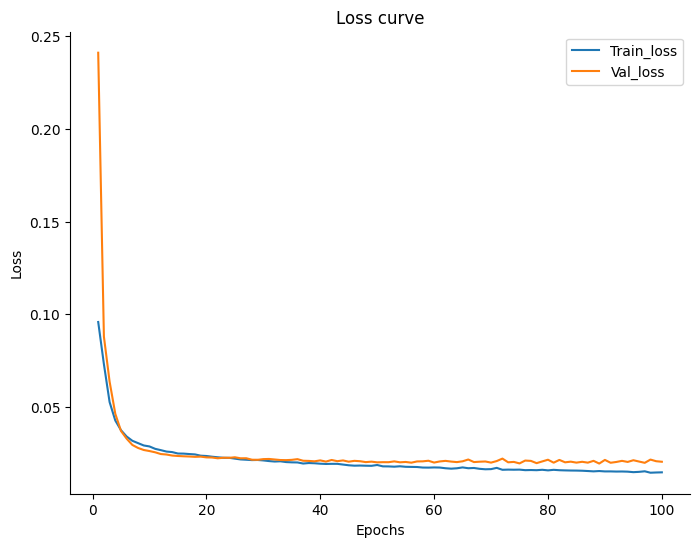

In [222]:
saved_path = '../../Model/scPred_test.pt'
scPred_training(scPred_test, train_data_iter, val_epi, val_exp, epochs=100, model_path=saved_path)

### 4. Evaluate the scPred performance on the test set

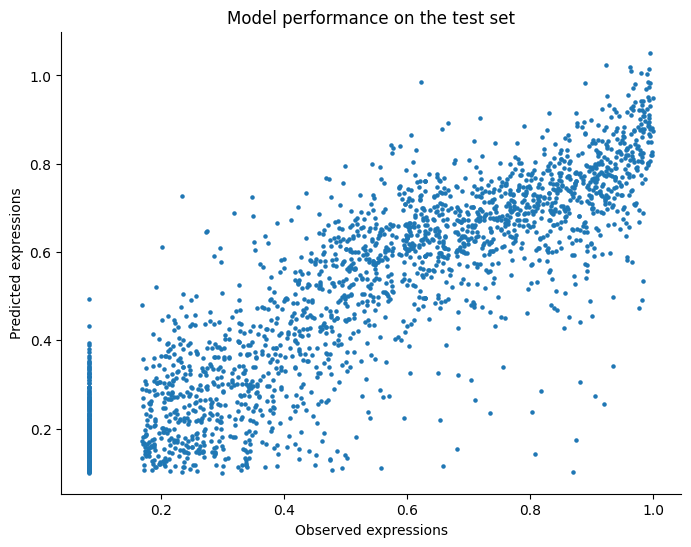

In [218]:
def plot_prediction(model, test_features, test_labels):
    model.eval()

    plt.figure(figsize=(8, 6))
    plt.scatter(test_labels, model(test_features).data, s=5)
    plt.xlabel('Observed expressions')
    plt.ylabel('Predicted expressions')
    plt.title('Model performance on the test set')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

plot_prediction(scPred_test, test_epi, test_exp)

### 5*. Re-load the trained model
When use the model to do new predictions, if you run the input normalization during the model training, use the same scaler of training data to normalize your new input data.

In [219]:
def load_model(filepath, model_class):

    model = model_class()
    model.load_state_dict(torch.load(filepath))

    return model

scPred_reload = load_model('../../Model/scPred_test.pt', scPred)